In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input, decode_predictions as inception_decode_predictions
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess_input, decode_predictions as densenet_decode_predictions
import os, json, pathlib, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

In [2]:
inception_model = InceptionV3(weights = 'imagenet')
densenet_model = DenseNet121(weights='imagenet')

In [3]:
densenet_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [3]:
folder_dir = "Places365_train2"
file_dir = pathlib.Path(folder_dir)
print(file_dir.exists())

total_img_cnt = len(list(file_dir.glob("*/*.JPG")))
print(total_img_cnt)

class_names = [name for name in os.listdir(folder_dir) if os.path.isdir(os.path.join(folder_dir, name))]
#class_names.remove("random_discovery")
print(class_names)


True
1500
['airfield', 'airplane_cabin', 'amusement_arcade', 'army_base', 'basketball_court_indoor', 'bus_station_indoor', 'corral', 'florist_shop_indoor', 'glacier', 'pagoda', 'swimming_pool_outdoor', 'television_room', 'ticket_booth', 'train_station_platform', 'windmill']


In [4]:
inception_size = (299, 299)
densenet_size = (224, 224)

In [5]:
def img_preprocess(image_path, model_target_size, model):
  print(model_target_size)
  img = image.load_img(image_path, target_size = model_target_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  if model == 'Inception':
    print("model = Inception")
    x = inception_preprocess_input(x)
  elif model == 'Densenet':
    print("model = Densenet")
    x = densenet_preprocess_input(x)
  else:
    return "error"
  return x


In [6]:
def get_gradcam_result(file_path, model_target_size, model_name, result_name):
  go_image = img_preprocess(file_path, model_target_size = model_target_size, model = model_name)

  with tf.GradientTape() as tape:
    #last_conv_layer = densenet_model.get_layer('conv5_block16_2_conv')
    last_conv_layer = densenet_model.get_layer('conv5_block16_concat')
    iterate = tf.keras.models.Model([densenet_model.inputs], [densenet_model.output, last_conv_layer.output])
    '''print(inception_model.inputs)
    print(inception_model.outputs)
    print(last_conv_layer.output)
    print(iterate)'''
    model_out, last_conv_layer = iterate(go_image)
    '''print(model_out.shape)
    print(last_conv_layer.shape)'''
    #class_out = model_out[:, np.argmax(model_out[0])]
    class_out = model_out[:, tf.argmax(model_out[0])]
    #print(class_out)
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = tf.keras.backend.mean(grads, axis = (0,1,2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis = -1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((7,7))

  img = cv2.imread(str(file_path))

  INTENSITY = 0.5
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(heatmap *255), cv2.COLORMAP_JET)
  img = heatmap * INTENSITY + img

  cv2.imwrite(result_name, img)

In [12]:
print(class_names)

['airfield', 'airplane_cabin', 'amusement_arcade', 'army_base', 'basketball_court_indoor', 'bus_station_indoor', 'corral', 'florist_shop_indoor', 'glacier', 'pagoda', 'swimming_pool_outdoor', 'television_room', 'ticket_booth', 'train_station_platform', 'windmill']


In [14]:
class_name = "airfield"

In [15]:
each_file_dir = pathlib.Path(folder_dir, class_name)
print(each_file_dir.exists())

file_lists = list(each_file_dir.glob("*.JPG"))
print(len(file_lists))

class_dir = pathlib.Path("Ace-results2", "ACE_DenseNet_"+class_name)
cam_results_dir = os.path.join(str(class_dir), 'cam_results/')
tf.io.gfile.makedirs(cam_results_dir)

True
100


In [7]:
for class_name in class_names:
  each_file_dir = pathlib.Path(folder_dir, class_name)
  print(each_file_dir.exists())

  file_lists = list(each_file_dir.glob("*.JPG"))
  #print(len(file_lists))

  class_dir = pathlib.Path("Ace-results2", "ACE_DenseNet_"+class_name)
  cam_results_dir = os.path.join(str(class_dir), 'cam_results2/')
  tf.io.gfile.makedirs(cam_results_dir)

  for i in range(len(file_lists)):
    file_name = file_lists[i]
    image_name = '0' * (3 - int(np.log10(i + 1))) + str(i + 1) + '.png'
    result_file_name = cam_results_dir + image_name
    #print(result_file_name)
    get_gradcam_result(file_name, densenet_size, "Densenet", result_file_name)

True
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
model = Densenet
(224, 224)
mode

In [24]:
print(cam_results_dir_list)

['Ace-results2\\ACE_DenseNet_airfield\\cam_results/', 'Ace-results2\\ACE_DenseNet_airplane_cabin\\cam_results/', 'Ace-results2\\ACE_DenseNet_amusement_arcade\\cam_results/', 'Ace-results2\\ACE_DenseNet_army_base\\cam_results/', 'Ace-results2\\ACE_DenseNet_basketball_court_indoor\\cam_results/', 'Ace-results2\\ACE_DenseNet_bus_station_indoor\\cam_results/', 'Ace-results2\\ACE_DenseNet_corral\\cam_results/', 'Ace-results2\\ACE_DenseNet_florist_shop_indoor\\cam_results/', 'Ace-results2\\ACE_DenseNet_glacier\\cam_results/', 'Ace-results2\\ACE_DenseNet_pagoda\\cam_results/', 'Ace-results2\\ACE_DenseNet_swimming_pool_outdoor\\cam_results/', 'Ace-results2\\ACE_DenseNet_television_room\\cam_results/', 'Ace-results2\\ACE_DenseNet_ticket_booth\\cam_results/', 'Ace-results2\\ACE_DenseNet_train_station_platform\\cam_results/', 'Ace-results2\\ACE_DenseNet_windmill\\cam_results/']


In [20]:
for i in range(len(file_lists)):
  file_name = file_lists[i]
  image_name = '0' * (3 - int(np.log10(i + 1))) + str(i + 1) + '.png'
  result_file_name = cam_results_dir + image_name
  print(result_file_name)
  get_gradcam_result(file_name, densenet_size, "Densenet", result_file_name)

Ace-results2\ACE_DenseNet_airfield\cam_results/0001.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0002.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0003.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0004.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0005.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0006.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0007.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0008.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0009.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0010.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0011.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0012.png
(224, 224)
model = D

C:\Users\dayeo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Ace-results2\ACE_DenseNet_airfield\cam_results/0057.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0058.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0059.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0060.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0061.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0062.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0063.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0064.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0065.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0066.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0067.png
(224, 224)
model = Densenet
Ace-results2\ACE_DenseNet_airfield\cam_results/0068.png
(224, 224)
model = D

In [24]:
class_dir = pathlib.Path("Ace-results3", "ACE_Inception_"+class_name)
print(class_dir)

Ace-results3\ACE_Inception_ambulance


In [25]:
print(file_lists[0])

imagenet_group\ambulance\ILSVRC2012_val_00001910.JPEG


In [ ]:
image_name = '0' * (3 - int(np.log10(i + 1))) + str(i + 1) + '.png'

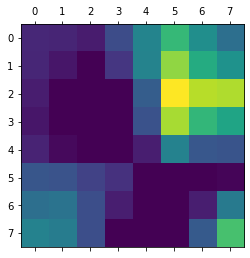

In [10]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((8,8))
plt.matshow(heatmap)
plt.show()

In [11]:
img = cv2.imread(str(file_lists[0]))

INTENSITY = 0.5
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(heatmap *255), cv2.COLORMAP_JET)
img = heatmap * INTENSITY + img

In [12]:
cv2.imwrite('cam1.jpg', img)

True